In [85]:
from gurobipy import *
import numpy as np
import logging
logging.basicConfig(level=logging.ERROR)
setParam('OutputFlag', 1)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


We will be building a centralized multi-quad control model based on [this](https://ieeexplore.ieee.org/document/1023918) paper. Given $N$ number of quads, we impose constraints over maximum and minimum velocities  $V_\max$ and $V_\min$, maximum and minimum forces $F_\max$, $F_\min$,  respectively. Next,
$i^{th}$ robot state is represented by $\{x_t^i, y_t^i, {Vx}_t^i, {Vy}_t^i, {Fx}_t^i, {Fy}_t^i \}$. We also need  decision variables $b_t^i$ and a discrete mission time $T_t$.

In [86]:
N = 2
T_MAX = 50
V_MAX = 2.5 * 0.225  # m/s
F_MAX = 2.5 * 0.294  # N
V_MIN = -V_MAX
F_MIN = - F_MAX

In [87]:
model = Model("MultiQuads")
x = [(i, t) for t in range(T_MAX) for i in range(N)]
get_name = lambda x: ["{}_{}_{}".format(x, i, t) for t in range(T_MAX) for i in range(N)]

x_i_t = model.addVars(x, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name=get_name("x"))
y_i_t = model.addVars(x, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name=get_name("y"))
Vx_i_t = model.addVars(x, vtype=GRB.CONTINUOUS, lb=V_MIN, ub=V_MAX, name=get_name("Vx"))
Vy_i_t = model.addVars(x, vtype=GRB.CONTINUOUS, lb=V_MIN, ub=V_MAX, name=get_name("Vy"))
Fx_i_t = model.addVars(x, vtype=GRB.CONTINUOUS, lb=F_MIN, ub=F_MAX, name=get_name("Fx"))
Fy_i_t = model.addVars(x, vtype=GRB.CONTINUOUS, lb=F_MIN, ub=F_MAX, name=get_name("Fy"))
Abs_Fx_i_t = model.addVars(x, vtype=GRB.CONTINUOUS, ub=F_MAX)
Abs_Fy_i_t = model.addVars(x, vtype=GRB.CONTINUOUS, ub=F_MAX)

b_i_t = model.addVars(x, vtype=GRB.BINARY, name=get_name("b"))
c = [t for t in range(T_MAX)]
T_t = model.addVars(c, vtype=GRB.CONTINUOUS, ub=GRB.INFINITY, name=["t_%d" % t for t in range(T_MAX)])

Let's introduce initial and goal states variables such that state $\mathbf{s} = \{x, y, vx, vy, fx, fy\}$

In [88]:
state_dim = [(i, t) for t in range(6) for i in range(N)]
s_0 = model.addVars(state_dim, vtype=GRB.CONTINUOUS, ub=GRB.INFINITY, name="s0_i")
s_g = model.addVars(state_dim, vtype=GRB.CONTINUOUS, ub=GRB.INFINITY, name="sg_i")

Our optimization goal is to minimize the following function
$   \min_{\mathbf{x}, \mathbf{u}, b, c} J = \sum_{i=1}^N \left(\sum_{t=t_0}^{T}  T(t) b_{d_i}^i(t) + \epsilon  \sum_{t=t_0}^{T} \left( \mid f_{x^i(t)} \mid + \mid f_{y^i(t)} \mid  \right)  \right)$

In [89]:
epsilon = 0.01
partA = quicksum(b_i_t[i, t] * T_t[t] for t in range(T_MAX) for i in range(N))
partB = quicksum(Abs_Fx_i_t[i, t] + Abs_Fy_i_t[i, t] for t in range(T_MAX) for i in range(N))
model.modelSense = GRB.MINIMIZE
model.setObjective(partA + epsilon * partB)

add force constraints such that $f^i_{x} (k)\sin(\frac{2\pi \gamma}{\Gamma}) + f^i_{y}(k)\cos(\frac{2\pi \gamma}{\Gamma})\leq F_{\max}^i$ and velocity constraints such that $v^i_{x}(k)\sin(\frac{2\pi \gamma}{\Gamma}) + v^i_{y}(k)\cos(\frac{2\pi \gamma}{\Gamma})\leq V_{\max}^i$

In [90]:
GAMMA = 10
for gamma in range(1, GAMMA + 1):
    for i in range(N):
        for t in range(T_MAX - 1):
            model.addConstr(
                Fx_i_t[i, t] * np.sin(2 * np.pi * gamma / GAMMA) + Fy_i_t[i, t] * np.cos(2 * np.pi * gamma / GAMMA) <= F_MAX)
            model.addConstr(
                Vx_i_t[i, t] * np.sin(2 * np.pi * gamma / GAMMA) + Vy_i_t[i, t] * np.cos(2 * np.pi * gamma / GAMMA) <= V_MAX)

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Add reachability constraints
\begin{aligned}
    &\forall i\in [1, N], \forall k \in [t_0,T]  \\
    & x^i(k)-x_g^i \leq  \epsilon + R( 1 - b_{d_i }^i(k)) \\
    & x^i(k)-x_g^i \geq -\epsilon- R( 1 - b_{d_i }^i(k))\\
    & y^i(k)-y_g^i\leq \epsilon+ R( 1 - b_{d_i }^i(k))\\
    & y^i(k)-y_g^i\geq -\epsilon-  R( 1 - b_{d_i }^i(k))
\end{aligned}

In [91]:
R = 1000000
xi = 1e-6
goal = [[10, 10], [0, 0]]
for i in range(N):
    model.addConstr(quicksum(b_i_t[i, t] for t in range(1, T_MAX)) == 1)
    model.addConstr( x_i_t[i, T_MAX - 1] == s_g[i, 0])
    model.addConstr( y_i_t[i, T_MAX - 1] == s_g[i, 1])
    model.addConstr(Vx_i_t[i, T_MAX - 1] == s_g[i, 2])
    model.addConstr(Vy_i_t[i, T_MAX - 1] == s_g[i, 3])
    model.addConstr(Fx_i_t[i, T_MAX - 1] == s_g[i, 4])
    model.addConstr(Fy_i_t[i, T_MAX - 1] == s_g[i, 5])

    for t in range(0, T_MAX):
        model.addConstr(x_i_t[i, t] - s_g[i, 0] <=  xi + R * (1 - b_i_t[i, t]))
        model.addConstr(x_i_t[i, t] - s_g[i, 0] >= -xi - R * (1 - b_i_t[i, t]))
        model.addConstr(y_i_t[i, t] - s_g[i, 1] <=  xi + R * (1 - b_i_t[i, t]))
        model.addConstr(y_i_t[i, t] - s_g[i, 1] >= -xi - R * (1 - b_i_t[i, t]))

add safety constraints
\begin{aligned}
   &\forall i\in [1, N], \forall k \in [t_0,T] \\
   &x^i(k)-x^{j}(k) &\geq d - R {c^{i,{j},1}(k)} \\
   &x^{j}(k)-x^i(k) &\geq d - R {c^{i,{j},2}(k)}\\
   &y^i(k)-y^{j}(k) &\geq d - R{c^{i,{j},3}(k)}\\
   &y^{j}(k)-y^i(k) &\geq d - R {c^{i,{j},4}(k)}\\
   &\sum_{z= 1}^{4}c^{i,{j},z}(k) &\leq 3
\end{aligned}

In [92]:
from itertools import combinations
d = 1.5
R = 1000000
q = [(t, i) for i in range(4) for t in range(T_MAX)]
q_t_k = model.addVars(q, vtype=GRB.BINARY)
for t in range(0, T_MAX):
    model.addConstr(x_i_t[0, t] - x_i_t[1, t] >= d - R * q_t_k[t, 0])
    model.addConstr(x_i_t[1, t] - x_i_t[0, t] >= d - R * q_t_k[t, 1])
    model.addConstr(y_i_t[0, t] - y_i_t[1, t] >= d - R * q_t_k[t, 2])
    model.addConstr(y_i_t[1, t] - y_i_t[0, t] >= d - R * q_t_k[t, 3])
    model.addConstr(quicksum(q_t_k[t, i] for i in range(4)) <= 3)

Add state transitions such that
\begin{aligned}
   \mathbf{x}_{t+1} = A \mathbf{x}_t + B \mathbf{u}_t
\end{aligned}
Here, we need some extra variables, i.e., time interval $dt$ and mass of the quad $m$.
For the sake of simplicity, Let's use same mass for all quads.

In [93]:
dt = 1
m = 2.8
A = np.zeros([4, 4])
B = np.zeros([4, 2])

A[0][0] = 1
A[1][1] = 1
A[2][2] = 1
A[3][3] = 1
A[0][2] = dt
A[1][3] = dt

B[0][0] = (0.5 / m) * dt ** 2
B[1][1] = (0.5 / m) * dt ** 2
B[2][0] = m * dt
B[3][1] = m * dt
model.addConstr(T_t[T_MAX - 1] <= T_MAX)
for i in range(N):
    for t in range(T_MAX - 1):
        X = np.array([x_i_t[i, t], y_i_t[i, t], Vx_i_t[i, t], Vy_i_t[i, t]])
        U = np.array([Fx_i_t[i, t], Fy_i_t[i, t]])
        X = np.matmul(A, X) + np.matmul(B, U)
        model.addConstr(x_i_t[i, t + 1] == X[0])
        model.addConstr(y_i_t[i, t + 1] == X[1])
        model.addConstr(Vx_i_t[i, t + 1] == X[2])
        model.addConstr(Vy_i_t[i, t + 1] == X[3])
        model.addConstr(T_t[t + 1] == T_t[t] + dt)
        model.addGenConstrAbs(Abs_Fx_i_t[i, t], Fx_i_t[i, t], "abs_fx_%d_%d" % (i, t))
        model.addGenConstrAbs(Abs_Fy_i_t[i, t], Fy_i_t[i, t], "abs_fy_%d_%d" % (i, t))

Add initial positions of quads where initial velocities and forces are zeros

In [94]:
start = [[0, 0], [10, 10]]
for i in range(N):
    model.addConstr(x_i_t[i, 0] ==  s_0[i, 0])
    model.addConstr(y_i_t[i, 0] ==  s_0[i, 1])
    model.addConstr(Vx_i_t[i, 0] == s_0[i, 2])
    model.addConstr(Vy_i_t[i, 0] == s_0[i, 3])
    model.addConstr(Fx_i_t[i, 0] == s_0[i, 4])
    model.addConstr(Fy_i_t[i, 0] == s_0[i, 5])

In [95]:
startState = [[0, 0, 0, 0, 0, 0, 0], [10, 10, 0, 0, 0, 0, 0]]
goalState = [[10, 10, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]]
for i, (s, g) in enumerate(zip(startState, goalState)):
    for j in range(6):
        model.addConstr(s_0[i, j] == s[j])
        model.addConstr(s_g[i, j] == g[j])

Congratulations! We made it. Let's leave the rest of works to the optimizer

In [96]:
model.optimize()

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 3151 rows, 1174 columns and 7267 nonzeros
Model fingerprint: 0xd0ca30b1
Model has 100 quadratic objective terms
Model has 196 general constraints
Variable types: 874 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+06]
  Objective range  [1e-02, 1e-02]
  QObjective range [2e+00, 2e+00]
  Bounds range     [6e-01, 1e+00]
  RHS range        [6e-01, 1e+06]
Presolve removed 1475 rows and 457 columns
Presolve time: 0.03s
Presolved: 1734 rows, 775 columns, 8616 nonzeros
Variable types: 607 continuous, 168 integer (168 binary)

Root relaxation: objective 4.969831e+01, 784 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   49.69831    0   12          -   49.698

Gurobi has already computed the solution for us. Now, let's decode the solution so that we can plot it.

In [97]:
import re
from collections import defaultdict

data = defaultdict(list)
param = ["x_", "y_", "Vx_", "Vy_", "Fx_", "Fy_", "b_"]

assert model.status == GRB.OPTIMAL, "No optimal solution found :("

for v in model.getVars():
    for p in param:
        for i in range(N):
            key = "{}{}".format(p, i)
            if re.search(key, v.varName):
                data[key].append(v.x)
    if re.search("t_", v.varName):
        data["time"].append(v.x)

We will be using matplotlib package to visualize the solution.

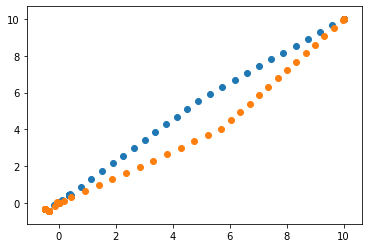

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
data.keys()

plt.cla()
plt.scatter(data['x_0'], data['y_0'])
plt.scatter(data['x_1'], data['y_1'])

Here you have it! An animation would have been nice, though!